In [96]:
from benchopt import BaseDataset, safe_import_context
import random
import torch
from deepinv.physics import Denoising, GaussianNoise
import imageio.v3 as iio
import numpy as np
import glob

import matplotlib.pyplot as plt

In [75]:
image_path = "./../data/images/BSD/train/"
random_state = 27
extension = ".png"
device = "cpu"
sigma = 0.1
n_samples = 10

In [76]:
it = 22

print("{:03d}".format(it))

022


In [77]:
# Generate pseudorandom data using `numpy`.
random.seed(random_state)
torch.manual_seed(random_state)

In [78]:
# Load the data
file_list = list(glob.glob(image_path + "*" + extension))
random.shuffle(file_list)

In [79]:
# Load images into a list
gt_img_list = [] # torch.zeros(self.n_samples)
for it in range(n_samples):
    gt_img = np.array(
        iio.imread(file_list[it])
    )
    # Scale to [0,1]
    gt_img = (gt_img - gt_img.min())/(gt_img.max() - gt_img.min())

    gt_img_list.append(gt_img)

In [80]:
x = torch.tensor(
    np.array(gt_img_list), dtype=torch.float32, device=device
) 


In [81]:
x = x[:,None,:,:]


In [82]:
# Define the forward model
physics = Denoising(noise=GaussianNoise(sigma))
# Generate the observations 
y = physics(x)

In [83]:
dict(x=x, y=y, physics=physics)

{'x': tensor([[[[0.0670, 0.0536, 0.0536,  ..., 0.1116, 0.1027, 0.0938],
           [0.0536, 0.0446, 0.0446,  ..., 0.1027, 0.0938, 0.0893],
           [0.0402, 0.0312, 0.0312,  ..., 0.0893, 0.0848, 0.0848],
           ...,
           [0.9152, 0.9330, 0.9509,  ..., 0.2679, 0.2589, 0.2500],
           [0.9107, 0.9330, 0.9509,  ..., 0.2723, 0.2545, 0.2455],
           [0.9152, 0.9330, 0.9509,  ..., 0.2589, 0.2679, 0.2455]]],
 
 
         [[[0.5315, 0.5039, 0.5118,  ..., 0.5827, 0.6299, 0.5276],
           [0.6142, 0.5551, 0.5354,  ..., 0.5866, 0.7008, 0.6181],
           [0.6772, 0.6063, 0.5945,  ..., 0.5433, 0.6260, 0.5709],
           ...,
           [0.8150, 0.8465, 0.7874,  ..., 0.9252, 0.9409, 0.9213],
           [0.7638, 0.7795, 0.7756,  ..., 0.8976, 0.8819, 0.8346],
           [0.7402, 0.7717, 0.7677,  ..., 0.8976, 0.9291, 0.9094]]],
 
 
         [[[0.8333, 0.8803, 0.8803,  ..., 0.4829, 0.4701, 0.5128],
           [0.8376, 0.8761, 0.8761,  ..., 0.5214, 0.5427, 0.5427],
           [0

In [84]:
x.shape

torch.Size([10, 1, 180, 180])

In [85]:
y.shape

torch.Size([10, 1, 180, 180])

In [86]:
physics

Denoising(
  (noise_model): GaussianNoise()
)

In [87]:
import deepinv as dinv
likelihood = dinv.optim.L2(sigma=physics.noise_model.sigma)

In [88]:
likelihood(x, y, physics)

tensor([16388.0977, 16263.1240, 16241.5850, 16008.5713, 16118.2715, 16241.5195,
        16124.8916, 16287.6816, 15906.1104, 16279.8018])

In [89]:
prior = dinv.optim.ScorePrior(
                denoiser=dinv.models.DnCNN(
                    pretrained="download_lipschitz",
                    in_channels=1,
                    out_channels=1,
                    device="cpu"
                )
            )

print(prior)

print(x.shape)

prior.grad(x, physics.noise_model.sigma)

ScorePrior(
  (denoiser): DnCNN(
    (in_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_list): ModuleList(
      (0-17): 18 x Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (out_conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (nl_list): ModuleList(
      (0-18): 19 x ReLU()
    )
  )
)
torch.Size([10, 1, 180, 180])


tensor([[[[ 0.6538,  0.1261,  0.5295,  ...,  0.5088,  0.2297, -0.1236],
          [ 0.2822,  0.0353,  0.2599,  ...,  0.2694, -0.0833, -0.2363],
          [-0.0742, -0.4256, -0.2105,  ..., -0.5662, -0.6373, -0.5013],
          ...,
          [ 0.0432,  0.0876, -0.1064,  ...,  0.1647,  0.0066, -0.0125],
          [-0.4402, -0.0241,  0.1502,  ...,  0.5663, -0.3885, -0.1678],
          [-0.1389,  0.1399,  0.5734,  ..., -0.2191,  0.5948, -0.4055]]],


        [[[-0.2547, -0.1637, -0.0870,  ...,  0.0024,  0.3381, -0.5335],
          [ 0.2562, -0.0473, -0.2842,  ..., -0.0584,  0.8009,  0.2760],
          [ 0.2843, -0.1094, -0.4800,  ..., -0.0983,  0.4109, -0.3417],
          ...,
          [ 0.4150,  0.8661, -0.5016,  ...,  0.1506,  0.7858,  0.2323],
          [-0.4236, -0.1941, -0.2787,  ..., -0.2257, -0.2611, -1.1673],
          [-0.4173,  0.1913, -0.2234,  ..., -0.3854,  0.7358,  0.1289]]],


        [[[-0.6311,  0.7800,  0.3606,  ..., -0.0139, -0.7479,  0.2502],
          [-0.5325,  0.249

In [92]:

x_window = []

for it in range(10):
    x_window.append(x + torch.rand_like(x))


In [93]:

x_stack = torch.stack(x_window, dim=0)
x_mean = torch.mean(x_stack, dim=0)




In [94]:
x_std_dev = torch.std(x_stack, dim=0)

In [103]:
from scipy.stats import pearsonr 

In [105]:

x_err = x - x_mean

x_std_dev.shape

torch.Size([10, 1, 180, 180])

In [106]:
x_err.shape

torch.Size([10, 1, 180, 180])

In [107]:
pearson_result = pearsonr(
    x_err.flatten().cpu().numpy(),
    x_std_dev.flatten().cpu().numpy()
)



ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [108]:
x_err.flatten().shape

torch.Size([324000])

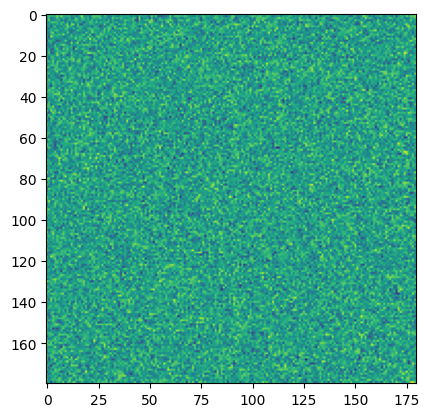

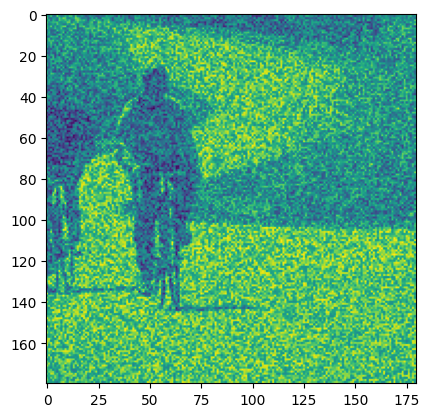

In [102]:
plt.figure()
plt.imshow(x_std_dev[1,0,:,:])
plt.show()


plt.figure()
plt.imshow(x_window[1][1,0,:,:])
plt.show()